In [87]:
import warnings
warnings.filterwarnings("ignore") 

In [88]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
df=pd.read_csv('C:\\workplace\\electricity_demand\\dataset\\AEP_hourly.csv')
df.sort_values('Datetime',ascending=True,inplace=True)
df.columns=['date_time','aep_mw']

In [89]:
df.head()

,date_time,aep_mw
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0


In [90]:
df.tail(1)

,date_time,aep_mw
116161,2018-08-03 00:00:00,14809.0


# Section 1: Preprocessing dataset

- data is defference as follow:

    - differencing to deterend the dataset

    - eliminate daily and weekly seasonality.

- That is:

$$Y_t=X_t-X_{t-1}-X_{t-24}+X_{t-25}-X_{t-168}+X_{t-169}+X_{t-192}-X_{t-193}.$$

In [91]:
df.head()

,date_time,aep_mw
2183,2004-10-01 01:00:00,12379.0
2184,2004-10-01 02:00:00,11935.0
2185,2004-10-01 03:00:00,11692.0
2186,2004-10-01 04:00:00,11597.0
2187,2004-10-01 05:00:00,11681.0


In [92]:
df['log_aep_mw']=np.log(df['aep_mw'])
df['log_aep_mw_diff']=df['log_aep_mw'].diff(1).diff(24).diff(168)
df.index=df['date_time']
df.drop('date_time',axis=1,inplace=True)
df.dropna(inplace=True)
df.head()

,aep_mw,log_aep_mw,log_aep_mw_diff
date_time,,,
2004-10-09 02:00:00,11597.0,9.358502,-0.004781
2004-10-09 03:00:00,11273.0,9.330166,0.003857
2004-10-09 04:00:00,11119.0,9.316411,-0.009352
2004-10-09 05:00:00,11064.0,9.311452,-0.005996
2004-10-09 06:00:00,11356.0,9.337502,0.002881


In [93]:
train_df=df.iloc[:-168*53-2]

In [94]:
dateTimeIndex=df.iloc[-168*53-2:].index
test_start_hear=dateTimeIndex[0]
test_start_hear

'2017-07-27 23:00:00'

In [95]:
def preparion (df,num_lags,lag_feature):
    df_prpocessed=pd.DataFrame(index=df.index,columns=['lags_{}'.format(i) for i in range(num_lags)]+['target'])
    df_prpocessed['target']=df[lag_feature].shift(-1)
    for i in range(num_lags):
        df_prpocessed['lags_{}'.format(i)]=df[lag_feature].shift(i)

    df_prpocessed.dropna(inplace=True)

    return df_prpocessed

In [96]:
df_prpocessed=preparion(train_df,168*4,'log_aep_mw_diff')

In [97]:
X_train=df_prpocessed.drop('target',axis=1)
y_train=df_prpocessed['target']

## Section 2: Training the models

In [98]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

In [99]:
def xgb_val(train_np,params,test_size,fold_number):

    tree_method=params['tree_method']
    objective_function=params['objective_function']
    num_trees_vec=params['n_estimators']
    depth_vec=params['max_depth']
    eta_vec=params['eta']

    prediction_dict={}
    count=1

    for n_estimators in num_trees_vec:
        fit_np,val_np=train_test_split(train_np,random_state=None,test_size=test_size)

        X_fit=fit_np[:,:-1]
        y_fit=fit_np[:,-1]

        X_val=val_np[:,:-1]
        y_val=val_np[:,-1]

        for depth in depth_vec:
            for eta in eta_vec:
                model=XGBRegressor(objective=objective_function,           
                                    n_jobs=-1,tree_method=tree_method,
                                    n_estimators=n_estimators,max_depth=depth,learning_rate=eta)
                model.fit(X_fit,y_fit)  
                pred=model.predict(X_val)
                score=mean_absolute_error(y_val,pred)
                prediction_dict['model_{}_fold_number_{}'.format(count,fold_number)]=[n_estimators,depth,eta,score]
                print(prediction_dict['model_{}_fold_number_{}'.format(count,fold_number)])
                count=count+1

    prediction_dict=pd.DataFrame(prediction_dict)
    prediction_dict.index=pd.Series(['n_estimators','max_depth','learning_rate','score'])
    prediction_dict=prediction_dict.transpose()
    return prediction_dict.sort_values('score',ascending=False)

In [100]:
params={'n_estimators':[100,150,200,250,300,350,400],'max_depth':[3,5,8,12,15],'eta':[0.1,0.05],'tree_method':'hist','objective_function':'reg:squarederror'}

In [101]:
model=XGBRegressor(objective='reg:squarederror',n_jobs=-1,tree_method='hist',
                                    n_estimators=100,max_depth=8,learning_rate=0.1)
model.fit(X_train,y_train)  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [102]:
res=y_train-model.predict(X_train)

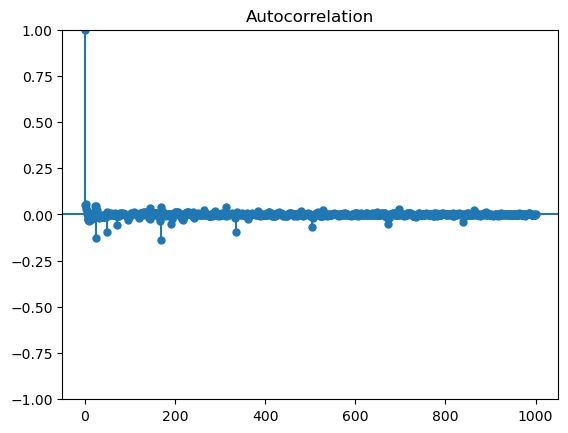

In [103]:
from statsmodels.graphics.tsaplots import plot_acf 
plot_acf(res,lags=1000)
plt.show()

# Section 2: Dayahead forecast

In [104]:
test_start_hear

'2017-07-27 23:00:00'

In [105]:
train_df.tail(1)

,aep_mw,log_aep_mw,log_aep_mw_diff
date_time,,,
2017-07-27 22:00:00,16960.0,9.738613,-0.000507


In [106]:
df_processed2=preparion(df,168*4,'log_aep_mw_diff')
df_processed2.drop_duplicates(inplace=True)
test_df=df_processed2[df_processed2.index>=test_start_hear]
X_test=test_df.drop('target',axis=1)
pred=pd.Series(model.predict(X_test),index=test_df.index)
df_2=df.copy()
df_2['forecast']=np.nan
df_2.loc[pred.index,'forecast']=pred.loc[pred.index]
df_2['forecast']=df_2['forecast'].shift(1)
df_2.reset_index(inplace=True)

In [107]:
selected_index=df_2[df_2['date_time']>test_start_hear].index

for i in selected_index:
    df_2.loc[i,'forecast']=df_2.loc[i,'forecast']+df_2.loc[i-1,'log_aep_mw']+(df_2.loc[i-24,'log_aep_mw']-df_2.loc[i-25,'log_aep_mw'])+\
        (df_2.loc[i-168,'log_aep_mw']-df_2.loc[i-169,'log_aep_mw'])-(df_2.loc[i-192,'log_aep_mw']-df_2.loc[i-193,'log_aep_mw'])
df_2.dropna(inplace=True)
df_2['forecast']=np.exp(df_2['forecast'].astype(float))

In [108]:
feature_name=pd.Series(X_train.columns)
feature_score=pd.Series(model.feature_importances_)
score_table=pd.concat([feature_name,feature_score],axis=1)
score_table.sort_values(1,ascending=False,inplace=True)
score_table.columns=['feature_name','feature_score']

In [109]:
score_table.head(20)

,feature_name,feature_score
167,lags_167,0.038093
0,lags_0,0.013816
23,lags_23,0.012453
536,lags_536,0.010686
66,lags_66,0.009853
1,lags_1,0.008931
85,lags_85,0.008561
121,lags_121,0.008445
335,lags_335,0.008243
666,lags_666,0.007733


# Section 3: Dayahead forecast

In [110]:
test_start_hear

'2017-07-27 23:00:00'

In [111]:
selected_date=datetime.strptime(test_start_hear,'%Y-%m-%d %H:%M:%S')+timedelta(hours=9)
selected_date=str(selected_date)
selected_date,test_start_hear

('2017-07-28 08:00:00', '2017-07-27 23:00:00')

In [112]:
X_train

,lags_0,lags_1,lags_2,lags_3,lags_4,lags_5,lags_6,lags_7,lags_8,lags_9,...,lags_662,lags_663,lags_664,lags_665,lags_666,lags_667,lags_668,lags_669,lags_670,lags_671
date_time,,,,,,,,,,,,,,,,,,,,,
2004-11-06 02:00:00,0.002515,0.007124,-0.007684,0.024950,0.029198,0.022446,-0.000933,0.024934,-0.008331,-0.017490,...,-0.010658,0.005915,0.000647,0.015412,-0.024021,0.002881,-0.005996,-0.009352,0.003857,-0.004781
2004-11-06 03:00:00,0.009439,0.002515,0.007124,-0.007684,0.024950,0.029198,0.022446,-0.000933,0.024934,-0.008331,...,0.010882,-0.010658,0.005915,0.000647,0.015412,-0.024021,0.002881,-0.005996,-0.009352,0.003857
2004-11-06 04:00:00,0.004975,0.009439,0.002515,0.007124,-0.007684,0.024950,0.029198,0.022446,-0.000933,0.024934,...,-0.005249,0.010882,-0.010658,0.005915,0.000647,0.015412,-0.024021,0.002881,-0.005996,-0.009352
2004-11-06 05:00:00,-0.011695,0.004975,0.009439,0.002515,0.007124,-0.007684,0.024950,0.029198,0.022446,-0.000933,...,0.015250,-0.005249,0.010882,-0.010658,0.005915,0.000647,0.015412,-0.024021,0.002881,-0.005996
2004-11-06 06:00:00,-0.017085,-0.011695,0.004975,0.009439,0.002515,0.007124,-0.007684,0.024950,0.029198,0.022446,...,0.008647,0.015250,-0.005249,0.010882,-0.010658,0.005915,0.000647,0.015412,-0.024021,0.002881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-27 17:00:00,-0.011950,-0.026666,-0.021684,-0.011594,-0.016858,0.002195,0.001965,0.019674,0.006179,0.000376,...,0.000746,-0.021330,0.006496,-0.014744,-0.011998,-0.020840,-0.007525,-0.001449,-0.008868,0.004004
2017-07-27 18:00:00,-0.026626,-0.011950,-0.026666,-0.021684,-0.011594,-0.016858,0.002195,0.001965,0.019674,0.006179,...,-0.000018,0.000746,-0.021330,0.006496,-0.014744,-0.011998,-0.020840,-0.007525,-0.001449,-0.008868
2017-07-27 19:00:00,0.004919,-0.026626,-0.011950,-0.026666,-0.021684,-0.011594,-0.016858,0.002195,0.001965,0.019674,...,-0.012848,-0.000018,0.000746,-0.021330,0.006496,-0.014744,-0.011998,-0.020840,-0.007525,-0.001449


In [113]:
def dayahead_forecast(df,selected_date):
   pred_df=pd.DataFrame(index=range(1,41),columns=['datetime','forecast'])
   new_X=preparion(df[df.index<=test_start_hear].tail(1000),168*4,'log_aep_mw_diff').drop('target',axis=1).tail(1)
   new_X.index=[0]
   #invest_mat=new_X
   for i in range(1,41):

      pred_df.loc[i,'datetime']=str(datetime.strptime(selected_date,'%Y-%m-%d %H:%M:%S')+timedelta(hours=i))
      pred=model.predict(new_X)
      pred_df.loc[i,'forecast']=pred
      new_X=new_X.shift(1,axis=1)
      new_X.loc[0,'lags_0']=pred
      #invest_mat=pd.concat([invest_mat,new_X])

   pred_df.index=pred_df['datetime']
   pred_df.drop('datetime',axis=1,inplace=True)
   
   target_df=df.loc[df.index<selected_date,['log_aep_mw']]
   target_df.columns=['forecast']
   target_df2=pd.concat([target_df,pred_df])
   target_df2.reset_index(inplace=True)
   target_df2.columns=['date_time','forecast']
   selected_index=target_df2.iloc[-40:].index
   
   for i in selected_index:
      target_df2.loc[i,'forecast']=target_df2.loc[i,'forecast']+target_df2.loc[i-1,'forecast']+(target_df2.loc[i-24,'forecast']-target_df2.loc[i-25,'forecast'])+\
        (target_df2.loc[i-168,'forecast']-target_df2.loc[i-169,'forecast'])-(target_df2.loc[i-192,'forecast']-target_df2.loc[i-193,'forecast'])
      
   target_df2=target_df2.iloc[-len(pred_df):]
   target_df2.index=target_df2['date_time']
   target_df2.drop('date_time',axis=1,inplace=True)
   target_df2['forecast']=np.exp(target_df2['forecast'].astype(float))
   target_df2=target_df2.iloc[16:]
   target_df2=target_df2.reset_index()
   target_df2.columns=['date_time','forecast']

   temp=df.reset_index()[['date_time','aep_mw']]
   temp.columns=['date_time','aep_mw']
   
   target_df2=temp.merge(target_df2,on=['date_time'])
   target_df2.index=target_df2['date_time']
   target_df2.drop('date_time',axis=1,inplace=True)
   return target_df2


In [114]:
a=df.reset_index()
a=a[a['date_time']>=selected_date]
a['date_time']=pd.to_datetime(a['date_time'])
date_time_list=a.loc[(a['date_time'].dt.hour==8),'date_time']
date_time_list[:-1]

112183   2017-07-28 08:00:00
112207   2017-07-29 08:00:00
112231   2017-07-30 08:00:00
112255   2017-07-31 08:00:00
112279   2017-08-01 08:00:00
                 ...        
120943   2018-07-28 08:00:00
120967   2018-07-29 08:00:00
120991   2018-07-30 08:00:00
121015   2018-07-31 08:00:00
121039   2018-08-01 08:00:00
Name: date_time, Length: 370, dtype: datetime64[ns]

In [117]:
forecast_dayahead=pd.DataFrame()
for d_t in date_time_list[:-1]:
    d_t=str(d_t)
    temp=dayahead_forecast(df,d_t)
    forecast_dayahead=pd.concat([forecast_dayahead,temp])
    print(d_t)

2017-07-28 08:00:00
2017-07-29 08:00:00
2017-07-30 08:00:00
2017-07-31 08:00:00
2017-08-01 08:00:00
2017-08-02 08:00:00
2017-08-03 08:00:00
2017-08-04 08:00:00
2017-08-05 08:00:00
2017-08-06 08:00:00
2017-08-07 08:00:00
2017-08-08 08:00:00
2017-08-09 08:00:00
2017-08-10 08:00:00
2017-08-11 08:00:00
2017-08-12 08:00:00
2017-08-13 08:00:00
2017-08-14 08:00:00
2017-08-15 08:00:00
2017-08-16 08:00:00
2017-08-17 08:00:00
2017-08-18 08:00:00
2017-08-19 08:00:00
2017-08-20 08:00:00
2017-08-21 08:00:00
2017-08-22 08:00:00
2017-08-23 08:00:00
2017-08-24 08:00:00
2017-08-25 08:00:00
2017-08-26 08:00:00
2017-08-27 08:00:00
2017-08-28 08:00:00
2017-08-29 08:00:00
2017-08-30 08:00:00
2017-08-31 08:00:00
2017-09-01 08:00:00
2017-09-02 08:00:00
2017-09-03 08:00:00
2017-09-04 08:00:00
2017-09-05 08:00:00
2017-09-06 08:00:00
2017-09-07 08:00:00
2017-09-08 08:00:00
2017-09-09 08:00:00
2017-09-10 08:00:00
2017-09-11 08:00:00
2017-09-12 08:00:00
2017-09-13 08:00:00
2017-09-14 08:00:00
2017-09-15 08:00:00


KeyboardInterrupt: 

<Axes: xlabel='date_time'>

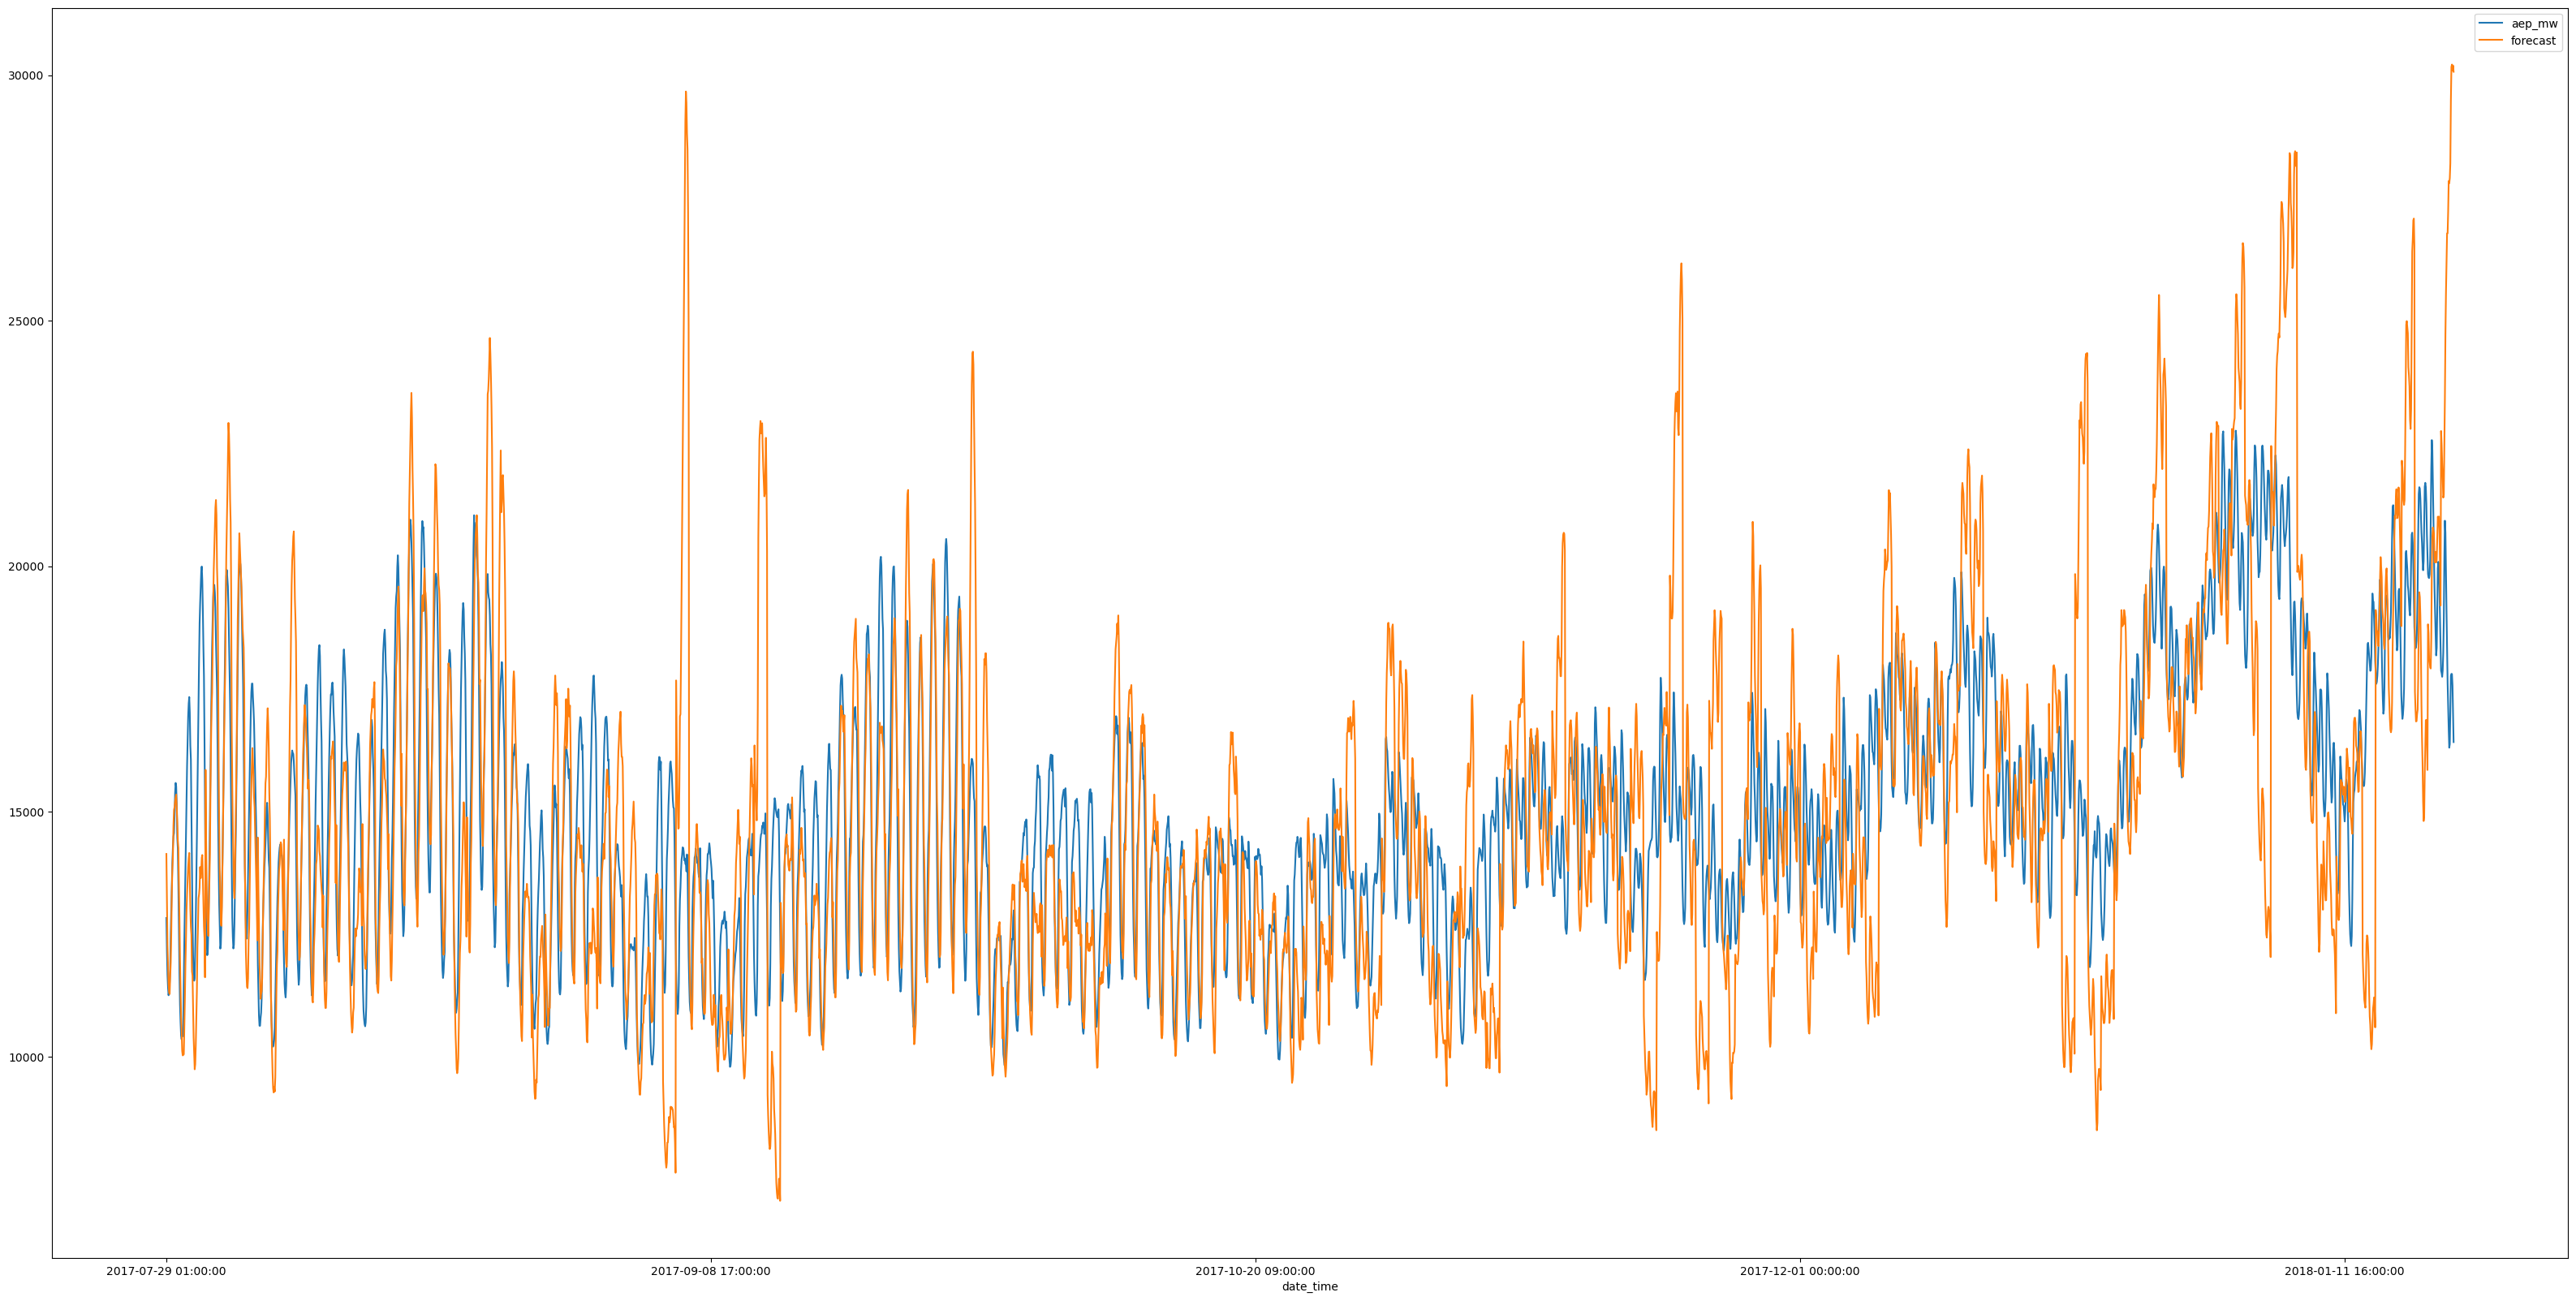

In [121]:
forecast_dayahead.plot(figsize=(40,20))

In [119]:
mean_absolute_percentage_error(forecast_dayahead.dropna()['aep_mw'],forecast_dayahead.dropna()['forecast'])

0.12607007896799877

In [ ]:
temp